In [13]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
import torch.nn as nn
import torch.autograd as autograd 
from torch.distributions import Categorical
import cv2
import time
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math


In [15]:
class PPOAgent():
    def __init__(self, input_shape, action_size, seed, device, gamma, alpha, beta, tau, update_every, batch_size, ppo_epoch, clip_param, actor_m, critic_m):
        """Initialize an Agent object.
        Params
        ======
            input_shape (tuple): dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            gamma (float): discount factor
            alpha (float): Actor learning rate
            beta (float): Critic learning rate 
            tau (float): Tau Value
            update_every: How often to update network
            batch_size (int): Mini Batch size to be used every epoch 
            ppo_epoch(int): Total No epoch for ppo
            clip_param(float): Clip Paramter
            actor_m(Model): Pytorch Actor Model
            critic_m(Model): PyTorch Critic Model
        """
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.ppo_epoch = ppo_epoch
        self.clip_param = clip_param

        # Actor-Network
        self.actor_net = actor_m(input_shape, action_size).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=self.alpha)

        # Critic-Network
        self.critic_net = critic_m(input_shape).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=self.beta)

        # Memory
        self.log_probs = []
        self.values    = []
        self.states    = []
        self.actions   = []
        self.rewards   = []
        self.masks     = []
        self.entropies = []

        self.t_step = 0

    def step(self, state, action, value, log_prob, reward, done, next_state):
        
        # Save experience in  memory
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.states.append(torch.from_numpy(state).unsqueeze(0).to(self.device))
        self.rewards.append(torch.from_numpy(np.array([reward])).to(self.device))
        self.actions.append(torch.from_numpy(np.array([action])).to(self.device))
        self.masks.append(torch.from_numpy(np.array([1 - done])).to(self.device))

        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
            self.learn(next_state)
            self.reset_memory()
                
    def act(self, state):
        """Returns action, log_prob, value for given state as per current policy."""
        
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        action_probs = self.actor_net(state)
        value = self.critic_net(state)

        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)

        return action.item(), log_prob, value
        
    def learn(self, next_state):
        next_state = torch.from_numpy(next_state).unsqueeze(0).to(self.device)
        next_value = self.critic_net(next_state)

        returns        = torch.cat(self.compute_gae(next_value)).detach()
        self.log_probs = torch.cat(self.log_probs).detach()
        self.values    = torch.cat(self.values).detach()
        self.states    = torch.cat(self.states)
        self.actions   = torch.cat(self.actions)
        advantages     = returns - self.values

        for _ in range(self.ppo_epoch):
            for state, action, old_log_probs, return_, advantage in self.ppo_iter(returns, advantages):

                dist = self.actor_net(state)
                value = self.critic_net(state)

                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(action)

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantage

                actor_loss  = - torch.min(surr1, surr2).mean()
                critic_loss = (return_ - value).pow(2).mean()
                
                loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

                # Minimize the loss
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()

        self.reset_memory()

    
    def ppo_iter(self, returns, advantage):
        memory_size = self.states.size(0)
        for _ in range(memory_size // self.batch_size):
            rand_ids = np.random.randint(0, memory_size, self.batch_size)
            yield self.states[rand_ids, :], self.actions[rand_ids], self.log_probs[rand_ids], returns[rand_ids, :], advantage[rand_ids, :]

    def reset_memory(self):
        self.log_probs = []
        self.values    = []
        self.states    = []
        self.actions   = []
        self.rewards   = []
        self.masks     = []
        self.entropies = []

    def compute_gae(self, next_value):
        gae = 0
        returns = []
        values = self.values + [next_value]
        for step in reversed(range(len(self.rewards))):
            delta = self.rewards[step] + self.gamma * values[step + 1] * self.masks[step] - values[step]
            gae = delta + self.gamma * self.tau * self.masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

In [16]:
import torch
import torch.nn as nn
import torch.autograd as autograd 
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        dist = Categorical(x)
        return dist
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

class CriticCnn(nn.Module):
    def __init__(self, input_shape):
        super(CriticCnn, self).__init__()
        self.input_shape = input_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [17]:
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Create our environment

In [18]:
env = gym.make("ALE/Breakout-v5")
env.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


The size of frame is:  (210, 160, 3)
No. of Actions:  18


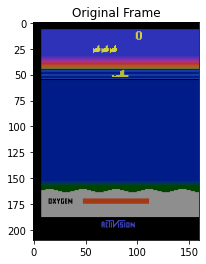

In [19]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

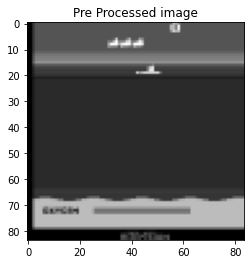

In [20]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

In [21]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

In [22]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0001          # Critic learning rate
TAU = 0.95
BATCH_SIZE = 32
PPO_EPOCH = 5
CLIP_PARAM = 0.2
UPDATE_EVERY = 1000    # how often to update the network 


agent = PPOAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, TAU, UPDATE_EVERY, BATCH_SIZE, PPO_EPOCH, CLIP_PARAM, ActorCnn,CriticCnn)

In [10]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Train the Agent 

In [23]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        steps = 0
        while True:
            steps += 1
            action, log_prob, value = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, value, log_prob, reward, done, next_state)
            scores_window.append(score)
            if done:
                break
            else:
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(np.mean(scores_window))              # save most recent score
        
        clear_output(True)
        fig = plt.figure(figsize=(15,8))
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores[-1]), end="")
    #agent.save_model('model/PPO_actor_result_path.pt','model/PPO_critic_result_path.pt')
    return scores

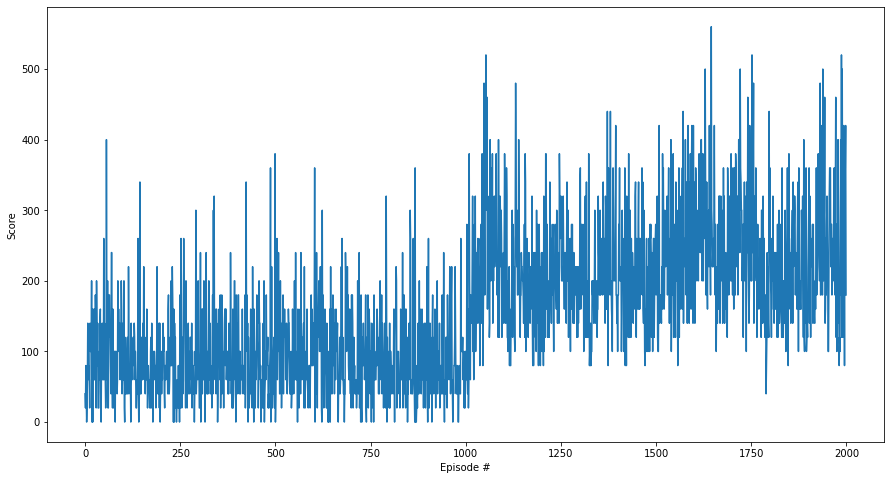

Episode 1000	Average Score: 180.00

In [24]:
scores = train(1000)

In [ ]:
import numpy as np
a=np.array(scores)
np.save('ppo_yibo_seaquest.npy',a)   # 保存为.npy格式
# 读取
#a=np.load('a.npy')
#a=a.tolist()

In [ ]:
mean_scores = []
for i in range(len(scores)):
    mean_scores.append(np.mean(scores_window))
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores[:100])), scores[:100])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.plot(np.arange(len(scores[:100])),mean_scores[:100],color = 'red')
plt.legend(['Score','AverageScore'], loc='upper left')
plt.title('PPO,average score : {}'.format(mean_scores[0]))
plt.show()
print('\rEpisode {}\tAverage Score: {:.2f}'.format(50, np.mean(scores_window)), end="")
print('\n')

In [2]:
mean_scores = []
for i in range(len(scores)):
    mean_scores.append(np.mean(scores_window))
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len([0,100,200,300,400,500])), scores[:50])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.plot(np.arange(len(scores[:50])),mean_scores[:50],color = 'red')
plt.legend(['Score','AverageScore'], loc='upper left')
plt.title('PPO,average score : {}'.format(mean_scores[0]))
plt.show()
print('\rEpisode {}\tAverage Score: {:.2f}'.format(50, np.mean(scores_window)), end="")
print('\n')

NameError: name 'scores' is not defined